In [1]:
# Imports

import pandas as pd
import numpy as np

import folium
import geopandas as gpd
import contextily as ctx

import matplotlib.pyplot as plt



In [2]:
# load data

loans = pd.read_csv('Original_data/loans.csv', low_memory=False)
coordinates = pd.read_csv('Project_csv/Geo_coordinates.csv', encoding='latin1', low_memory=False)

In [3]:
# Clean coordinates

# Extract needed columns
coords = coordinates[['Postcode (8 char)', 'Latitude', 'Longitude', 'County Code (2025)']]

# Change postcode format from XXX XXX to XXX
coords = coords.copy()
coords["Post"] = coords["Postcode (8 char)"].str.split().str[0]


In [4]:
# Clean Loans
loans_coords = loans[['postcode_district', 'loan_status']]

In [5]:
# Merge loans postcode with coordinates by post 
loans_full = loans_coords.merge(
    coords,
    how="left",
    left_on="postcode_district",
    right_on="Post"
)

In [18]:
# Save the dataset because merge is slow
# loans_full.to_csv('Project_csv/Geo_data.csv')
# loans  = pd.read_csv('Project_csv/Geo_data')

In [6]:
loans_full.head(2)

,postcode_district,loan_status,Postcode (8 char),Latitude,Longitude,County Code (2025),Post
0,L69,Fully Paid,L69 1AA,53.406416,-2.975554,E99999999,L69
1,L69,Fully Paid,L69 1AB,53.406416,-2.975554,E99999999,L69


In [8]:
# Group by county number of loans by status

cols = ["County Code (2025)", "loan_status", "Latitude", "Longitude"]
temp = loans_full[cols].copy()

# Optional but recommended: drop bad coords if you have them
temp = temp[temp["Latitude"].between(49, 61) & temp["Longitude"].between(-9, 3)]

# Round to avoid tiny floating noise (tune decimals if needed)
temp["lat_r"] = temp["Latitude"].round(5)
temp["lon_r"] = temp["Longitude"].round(5)

# 1. count per (county, status, lat, lon)
counts = (
    temp.groupby(["County Code (2025)", "loan_status", "lat_r", "lon_r"], sort=False)
      .size()
      .reset_index(name="loan_count")
)

# 2. pick the most common lat/lon per (county, status)
out = (
    counts.sort_values("loan_count", ascending=False)
          .drop_duplicates(["County Code (2025)", "loan_status"], keep="first")
          .rename(columns={"lat_r": "Latitude", "lon_r": "Longitude"})
          .reset_index(drop=True)
)


In [9]:
out.head(2)

,County Code (2025),loan_status,Latitude,Longitude,loan_count
0,E99999999,Fully Paid,51.51713,-0.13422,400550
1,E10000003,Fully Paid,52.20936,0.14826,157910


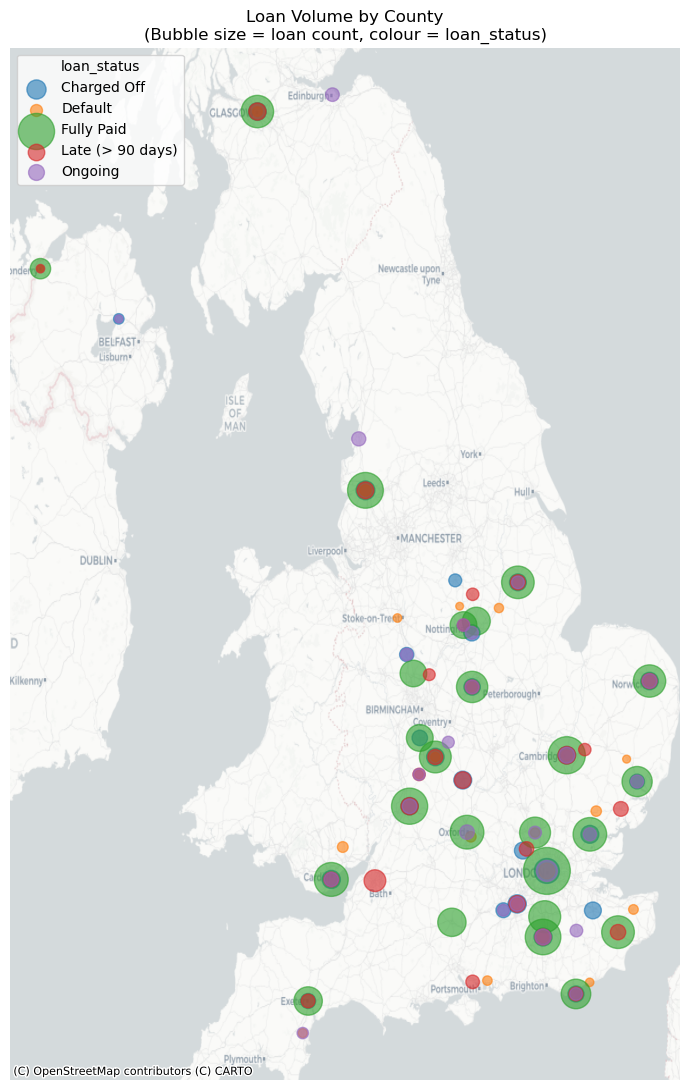

In [11]:
#  Plot baubles on the UK map
    
# bubble sizes (sqrt scaling)
clean_all_loans["size"] = np.sqrt(clean_all_loans["loan_count"]) * 1.8

# GeoDataFrame in lat/lon
gdf = gpd.GeoDataFrame(
    clean_all_loans,
    geometry=gpd.points_from_xy(clean_all_loans["Longitude"], clean_all_loans["Latitude"]),
    crs="EPSG:4326"
)

# Project to Web Mercator for basemap tiles
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(7, 11))

# Plot each loan_status as a separate layer (for different colors + legend)
for status, sub in gdf.groupby("loan_status"):
    ax.scatter(
        sub.geometry.x,
        sub.geometry.y,
        s=sub["size"],
        alpha=0.6,
        label=status
    )

# Add basemap (static)
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

ax.set_axis_off()
ax.set_title("Loan Volume by County\n(Bubble size = loan count, colour = loan_status)")
ax.legend(title="loan_status", loc="upper left")

plt.tight_layout()
plt.show()


In [13]:
#Plot an interactive map 

# Take at most 5000 random points to avoid overloading the browser / kernel
loans_sample = loans_full.dropna(subset=["Latitude", "Longitude"]).sample(
    n=min(5000, len(loans_full)),
    random_state=0
)

# Base map (UK)
m = folium.Map(location=[54.5, -3.0], zoom_start=6)

# Status → color mapping
status_colors = {
    "Fully Paid": "green",
    "Current": "blue",
    "Charged Off": "red",
    "Default": "darkred",
    "Late": "orange",
}

for _, row in loans_sample.iterrows():
    status = row["loan_status"]
    color = status_colors.get(status, "gray")
    
    folium.CircleMarker(
        location=[row["Latitude"], row["Longitude"]],
        radius=4,
        popup=(
            f"{row['postcode_district']} - {row['Postcode (8 char)']}<br>"
            f"Status: {status}"
        ),
        color=color,
        fill=True,
        fill_opacity=0.8,
    ).add_to(m)

m.save("uk_loan_map.html")
